In [1]:
import json
from pathlib import Path
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
DATA_DIR = Path("/Users/jonas/Documents/Bachelorarbeit/injection_molding_simulation/data")

In [3]:
RAW_DIR = DATA_DIR / "raw"

In [4]:
file_names = [fn for fn in os.listdir(RAW_DIR) if not fn.startswith(".")]
studies = []
for fn in file_names:
    with open(RAW_DIR / fn, "r") as json_file:
        s = json.load(json_file)
    studies.append(s)
print(f"Number of studies: {len(studies)}")

Number of studies: 50


In [5]:
max_fill_times = [max(s["fill_time"]) for s in studies]

In [6]:
mean_max_fill_times = sum(max_fill_times) / len(max_fill_times)
print(f"mean max fill time: {mean_max_fill_times}")

mean max fill time: 5.481287999999999


In [7]:
import sys
SRC_DIR = Path("/Users/jonas/Documents/Bachelorarbeit/injection_molding_simulation/src")
sys.path.append(str(SRC_DIR))

In [8]:
from dataset import InjectionMoldingDataset

In [9]:
dataset = InjectionMoldingDataset(0.004, 0.5, skip_processing=True)
print(f"Dataset has length of: {len(dataset)}")

Dataset has length of: 580


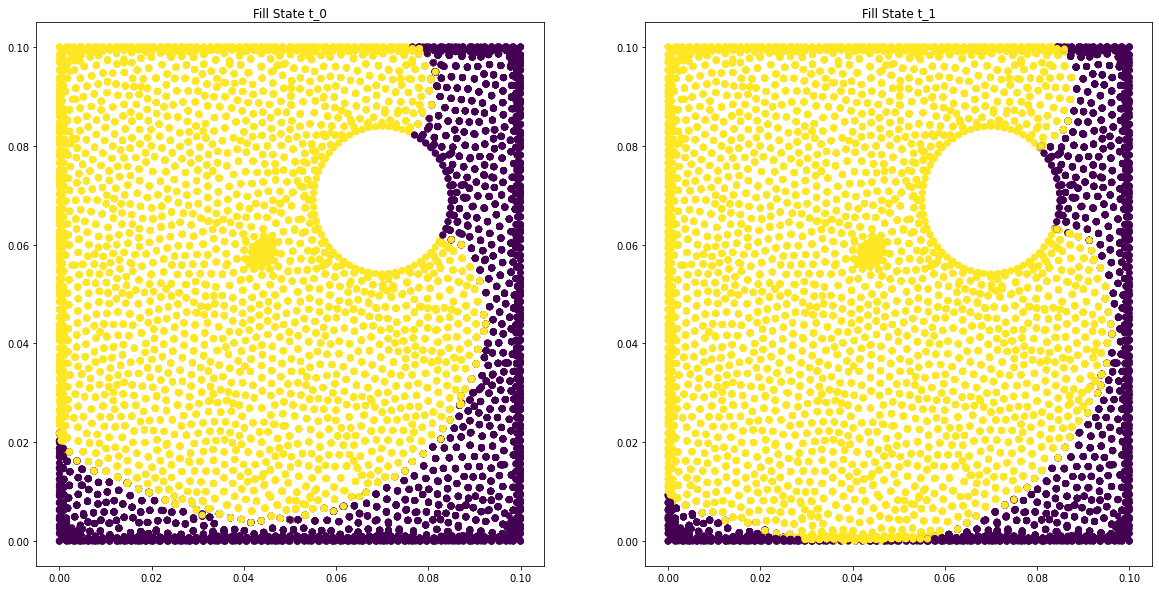

In [10]:
d = dataset[42]
fig, axes = plt.subplots(1, 2, figsize=[20, 10])
ax_left, ax_right = axes

xs, ys, zs = d.pos.T
ax_left.set_title("Fill State t_0")
ax_left.scatter(xs, ys, c=d.x[:, 0])
ax_right.set_title("Fill State t_1")
ax_right.scatter(xs, ys, c=d.y[:, 0])

plt.show()

In [11]:
from scipy.spatial import Delaunay
import numpy as np


def alpha_shape(points, alpha, only_outer=True):
    """
    Compute the alpha shape (concave hull) of a set of points.
    :param points: np.array of shape (n,2) points.
    :param alpha: alpha value.
    :param only_outer: boolean value to specify if we keep only the outer border
    or also inner edges.
    :return: set of (i,j) pairs representing edges of the alpha-shape. (i,j) are
    the indices in the points array.
    """
    assert points.shape[0] > 3, "Need at least four points"

    def add_edge(edges, i, j):
        """
        Add a line between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            assert (j, i) in edges, "Can't go twice over same directed edge right?"
            if only_outer:
                # if both neighboring triangles are in shape, it is not a boundary edge
                edges.remove((j, i))
            return
        edges.add((i, j))

    tri = Delaunay(points)
    edges = set()
    # Loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.simplices:
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]
        # Computing radius of triangle circumcircle
        # www.mathalino.com/reviewer/derivation-of-formulas/derivation-of-formula-for-radius-of-circumcircle
        a = np.sqrt((pa[0] - pb[0]) ** 2 + (pa[1] - pb[1]) ** 2)
        b = np.sqrt((pb[0] - pc[0]) ** 2 + (pb[1] - pc[1]) ** 2)
        c = np.sqrt((pc[0] - pa[0]) ** 2 + (pc[1] - pa[1]) ** 2)
        s = (a + b + c) / 2.0
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))
        circum_r = a * b * c / (4.0 * area)
        if circum_r < alpha:
            add_edge(edges, ia, ib)
            add_edge(edges, ib, ic)
            add_edge(edges, ic, ia)
    return edges

In [12]:
def get_concave_hull_points(points, alpha):
    as_edges = alpha_shape(points, alpha)
    point_indexes = sorted(list(set(np.array(list(as_edges)).ravel())))
    points_in_flowfront = np.array([points[i].tolist() for i in point_indexes])
    return points_in_flowfront

In [13]:
def get_flow_front(pos, fill_encoding):
    filled_nodes = pos[fill_encoding[:, 0].bool()]
    nodes_on_flow_front = get_concave_hull_points(filled_nodes[:, :2], 0.01)
    return nodes_on_flow_front

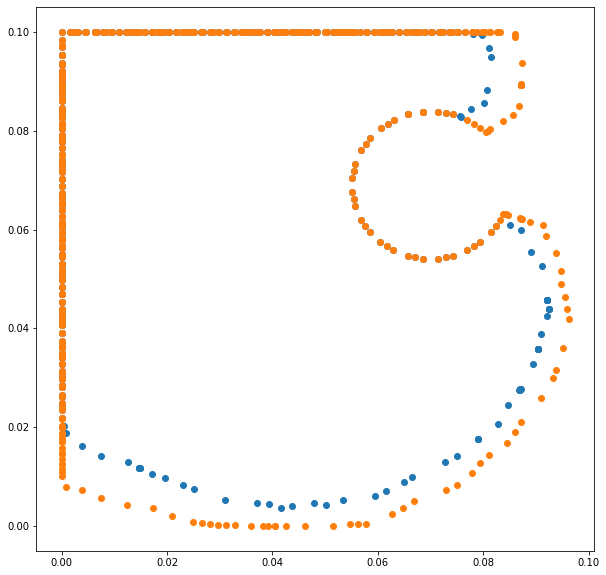

In [14]:
d = dataset[42]
flowfront_x = get_flow_front(d.pos, d.x)
flowfront_y = get_flow_front(d.pos, d.y)

plt.figure(figsize=(10, 10))
plt.scatter(*flowfront_x.T)
plt.scatter(*flowfront_y.T)
plt.show()

In [15]:
distances = []
for p in flowfront_x:
    d = np.min(np.linalg.norm(p - flowfront_y, axis=1))
    distances.append(d)

print(f"min distance: {np.min(distances)}")
print(f"mean distance: {np.mean(distances)}")
print(f"max distance: {np.max(distances)}")

min distance: 0.0
mean distance: 0.0009071693621340609
max distance: 0.008781171557987098


In [23]:
connection_range = 0.004
num_layers = 20

net_range = connection_range * num_layers
print(f"net range: {net_range}")

net range: 0.08


In [17]:
import torch
from torch.nn import functional as F

In [18]:
model = torch.load("model_epoch_9.pt", map_location="cpu")

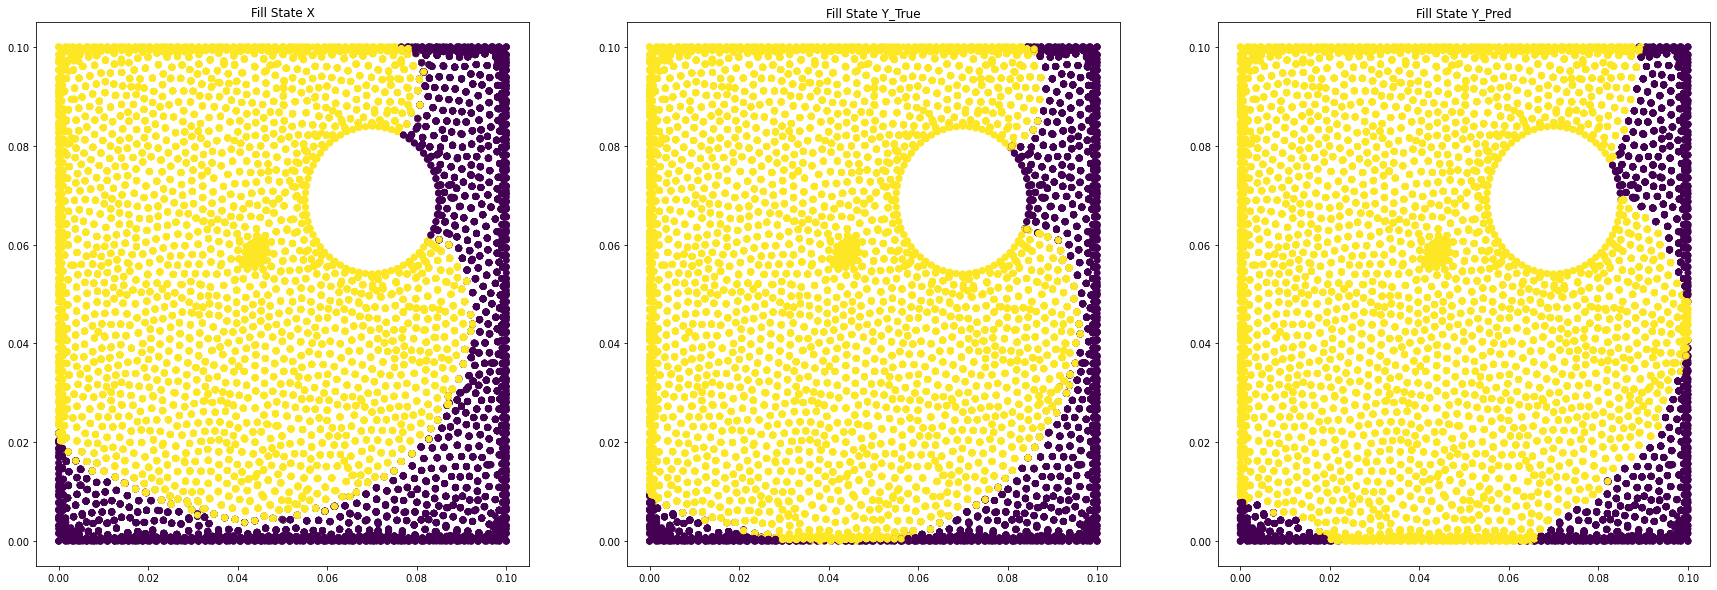

In [22]:
d = dataset[42]

with torch.no_grad():
    pred = F.softmax(model(d), dim=1).round()

fig, axes = plt.subplots(1, 3, figsize=(30, 10))
ax1, ax2, ax3 = axes
ax1.set_title("Fill State X")
ax1.scatter(*d.pos[:, :2].T, c=d.x[:, 0])
ax2.set_title("Fill State Y_True")
ax2.scatter(*d.pos[:, :2].T, c=d.y[:, 0])
ax3.set_title("Fill State Y_Pred")
ax3.scatter(*d.pos[:, :2].T, c=pred[:, 0])
plt.show()